# Checking confident regions

DV makes examples from the data for non variant and variant sites that we give it. In model systems this is well curated, however here we are making our own. To do this we have sequenced trios, which enables us to check (some) loci for mendelian consistency. Those that match segregation expectations can be used to show DV what non variant or variant sites look like. 

***Variant confident regions***

These are those that are either fixed for different homozygous alleles in the parents (E.g. 0/0 in father and 1/1 in the mother, and thus 0/1 in the offspring) or both parents are fixed for the alt allele, so father, mother and offspring should have 1/1 genotypes. (We ignore multi allelic loci here (e.g. 1/2, or 2/2). 

Variant filtering in the parents was strict, requiring good coverage, genotype quality and allele depth ratio scores. 


***Non-Variant confident regions***

In the case of non-var confident sites, we do not want to use the offspring information to identify positions to use. This is because, if we filter sites in the offspring, we will remove signal for false positive SNPs, and thus the model will not be as good at detecting such events. **Note** *that when we say "non variant" here, we mean no heterozygous posistions, and no positions which are homozygous for a non-reference allele.*

The approach here is therefore to identify loci that are homozygous reference in both parents. Such loci should be homozygous in the offspring as well. We therefore filtered for homozygous calls in the parents which have very good support (i.e. high depth, good GQ scrores). 

However, while it will not affect which loci we include for the training, I would like to characterise the sites that we are using in the offspring. To ask how many loci look like SNPs, how good the evidence for these SNPs is, and which false positive cases we are including in the training data. ***Note, some novel SNPs are possible, but low mutation rates mean that these are likely to be very rare (1 or 2 per chromosome)*** 


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import gzip as gz
from collections import Counter

# Functions

## VCF

In [2]:
def parse_sample_field(GT_field):
    
    """
    Parse the genotype field for a given sample
    """
    ## not converting types here, as there are some annoying exceptions. Deal with this downstream
    
    GT = GT_field.split(":")[0]
    AD = GT_field.split(":")[1]      
    DP = GT_field.split(":")[2]
    GQ = GT_field.split(":")[3] 
        
    return GT, AD, DP, GQ

In [3]:
def parse_VCF(vcf_path, father_index, mother_index, offspring_index):
    
    out_dict = {}

    with gz.open(vcf_path, 'rt') as vcf:

        line_index = 0

        for line in vcf:

            if line.startswith('#CHROM'):  ## set up dictionary with sample names

                father = line.split()[father_index]
                out_dict[father] = {}
                out_dict[father]["index"] = father_index
                out_dict[father]["coords"] = []
                out_dict[father]["GTs"] = []
                out_dict[father]["DPs"] = []
                out_dict[father]["GQs"] = []
                out_dict[father]["ADs"] = []

                mother = line.split()[mother_index]
                out_dict[mother] = {}
                out_dict[mother]["index"] = mother_index
                out_dict[mother]["coords"] = []
                out_dict[mother]["GTs"] = []
                out_dict[mother]["DPs"] = []
                out_dict[mother]["GQs"] = []
                out_dict[mother]["ADs"] = []

                offspring = line.split()[offspring_index]
                out_dict[offspring] = {}
                out_dict[offspring]["index"] = offspring_index
                out_dict[offspring]["coords"] = []
                out_dict[offspring]["GTs"] = []
                out_dict[offspring]["DPs"] = []
                out_dict[offspring]["GQs"] = []
                out_dict[offspring]["ADs"] = []            

                print("Father:", father)
                print("Mother:", mother)
                print("Offspring:", offspring)

            if not line.startswith("#"):# and line_index <= 10: ## for the locus lines

                CHROM = line.split()[0]
                POS = line.split()[1]
                COORDS = "%s_%s" % (CHROM, POS)

                for sample in out_dict:

                    sample_field = line.split()[out_dict[sample]["index"]]
                    sample_GT, sample_AD, sample_DP, sample_GQ = parse_sample_field(sample_field)

                    out_dict[sample]["coords"].append(COORDS)
                    out_dict[sample]["GTs"].append(sample_GT)
                    out_dict[sample]["DPs"].append(sample_DP)
                    out_dict[sample]["GQs"].append(sample_GQ)
                    out_dict[sample]["ADs"].append(sample_AD)

                line_index +=1 
                
    return out_dict

### Check Mendelian segregation & GTs, DPs and ADs.

In [4]:
def mend_eval(outdict, father, mother, offspring):

    mendel_pass_patterns = [("1/1","1/1","1/1"), ## all hom_alt
                            ("1/1","0/0","0/1"), ## father hom_alt, mother hom_ref, offspring het
                            ("0/0","1/1","0/1")] ## father hom_ref, mother hom_alt, offspring het
    
    mendel_passes = 0
    mendel_fails = 0
    failed_loci = []
    
    N_loci = len(outdict[father]["GTs"])
    
    for i in range(N_loci):
        trio_GTs = (outdict[father]["GTs"][i],
                    outdict[mother]["GTs"][i], 
                    outdict[offspring]["GTs"][i])

        trio_GTs = tuple([i.replace("|", "/") for i in trio_GTs])
        
        ## find trios that do or do not fit mendelian expectations

        if trio_GTs in mendel_pass_patterns:
            mendel_passes += 1
        else:
            mendel_fails += 1
            failed_loci.append(outdict[offspring]["coords"][i])
                               
    print("%s (%s%%) loci PASSED mendelian segregation check" % (mendel_passes, np.round(((mendel_passes/N_loci)*100),2)))
    print("%s (%s%%) loci FAILED mendelian segregation check" % (mendel_fails, np.round(((mendel_fails/N_loci)*100),2))) 
    
    return failed_loci
        

### Check Depth fields

In [5]:
def check_depths(out_dict, sample):
        
    depth_fails = []
    for i in range(len(out_dict[sample]["DPs"])):
        if not out_dict[sample]["DPs"][i].isnumeric():
            depth_fails.append(out_dict[sample]["coords"][i])
        elif out_dict[sample]["DPs"][i] == "0":
            depth_fails.append(out_dict[sample]["coords"][i])
            
    print("%s depth fails for sample: %s" % (len(depth_fails), sample))
            
    return depth_fails
            

### Check GQ fields

In [6]:
def check_GQs(out_dict, sample):
        
    GQ_fails = []
    for i in range(len(out_dict[sample]["GQs"])):
        if not out_dict[sample]["GQs"][i].isnumeric():
            GQ_fails.append(out_dict[sample]["coords"][i])
            #print(out_dict[sample]["coords"][1], out_dict[sample]["GQs"][i])
            
    print("%s GQ fails for sample: %s" % (len(GQ_fails), sample))
            
    return GQ_fails

### Check AD fields

In [7]:
def check_ADs(out_dict, sample):
        
    AD_fails = []
    for i in range(len(out_dict[sample]["ADs"])):
        if not all([out_dict[sample]["ADs"][i].split(",")[0].isnumeric(),
                    out_dict[sample]["ADs"][i].split(",")[1].isnumeric()]):  
            AD_fails.append(out_dict[sample]["coords"][i])
            print(out_dict[sample]["coords"][i])
        elif np.sum([int(i) for i in out_dict[sample]["ADs"][i].split(",")]) == 0:
            AD_fails.append(out_dict[sample]["coords"][i])
            
    print("%s AD fails for sample: %s" % (len(AD_fails), sample))
            
    return AD_fails
            

### All checks function

In [8]:
def vcf_checks(cross, vcf_path):

    outdict = parse_VCF(vcf_path, 9, 10, 11)

    mendel_fails = mend_eval(outdict, "%s_male_par" % cross, "%s_fem_par" % cross, "%s_male_1" % cross)

    male_AD_fails = check_ADs(outdict,"%s_male_par" % cross)
    fem_AD_fails = check_ADs(outdict,"%s_fem_par" % cross)
    male_1_AD_fails = check_ADs(outdict,"%s_male_1" % cross)

    male_GQ_fails = check_GQs(outdict,"%s_male_par" % cross)
    fem_GQ_fails = check_GQs(outdict,"%s_fem_par" % cross)
    offspring_GQ_fails = check_GQs(outdict,"%s_male_1" % cross)

    male_depth_fails = check_depths(outdict,"%s_male_par" % cross)
    fem_depth_fails = check_depths(outdict,"%s_fem_par" % cross)
    offspring_depth_fails = check_depths(outdict,"%s_male_1" % cross)

    all_fails = mendel_fails+male_AD_fails+fem_AD_fails+male_1_AD_fails+male_GQ_fails+fem_GQ_fails+offspring_GQ_fails+male_depth_fails+fem_depth_fails+offspring_depth_fails 

    all_fails_uniq = list(Counter(all_fails).keys())

    print("\n%s failed loci in total" % len(all_fails_uniq))
    
    return all_fails_uniq

In [68]:
def multi_plot_VCF(cross_outdict, cross):

    ## plotting samples and metrics in a grid

    plt.figure(figsize = (20, 15))

    samples = ["%s_male_par" % cross, "%s_fem_par" % cross, "%s_male_1" % cross]
    metrics = ["GTs", "DPs", "ADs", "GQs"]

    subplot_index = 1

    for sample in samples:

        ## plot GTs
        plot_GTs(cross_outdict, sample, 3, 4, subplot_index)

        ## plot GQs
        plot_GQs(cross_outdict, sample, 3, 4, subplot_index+1)

        ## plot depths 
        plot_depths(cross_outdict, sample, 3, 4, subplot_index+2)

        ## plot ADRs
        plot_ADRs(cross_outdict, sample, 3, 4, subplot_index+3)

        subplot_index += 4


    plt.show()

### Define plotting functions (VCF)

In [9]:
def plot_GTs(out_dict, sample, plot_cols, plot_rows, subplot_index):
 
    ## plot GTs

    plt.subplot(plot_cols,plot_rows,subplot_index)

    counts = Counter([i.replace("|", "/") for i in out_dict[sample]["GTs"]])
    N_hom_ref = counts["0/0"]
    N_hom_alt = counts["1/1"]
    N_het = counts["0/1"]
    labels = ["0/0", "1/1", "0/1"]
   
    plt.bar([1,2,3], 
            [N_hom_ref, N_hom_alt, N_het],
            color = "black")
    plt.xticks([1,2,3],
               labels)
    
    plt.ylabel("N_loci")
    
    if "male_1" in sample:
        plt.xlabel("Genotype")
    
    plt.title(sample)
    
    return counts

In [10]:
def plot_depths(out_dict, sample, plot_cols, plot_rows, subplot_index):
    
    ## plot depths 
    
    plt.subplot(plot_cols,plot_rows,subplot_index)
    
    data=[int(i) for i in out_dict[sample]["DPs"]]
    plt.hist(data, bins = (max(data)-min(data)), color = "black")
    plt.vlines(np.mean(data), 0, 40000, colors="red", linestyles='dashed') 
    
    plt.xlim(0, 60)
    #plt.ylim(0,40000)
    
    #plt.ylabel("N loci")
    if "male_1" in sample:
        plt.xlabel("Depth")
    
    plt.title(sample)
    

In [11]:
def plot_GQs(out_dict, sample, plot_cols, plot_rows, subplot_index):
    
    ## plot GQs
    
    plt.subplot(plot_cols,plot_rows,subplot_index)
    
    data = []
    for GQ in out_dict[sample]["GQs"]:
        if GQ != ".":
            data.append(int(GQ))
            
    plt.hist(data, bins = max(data)-min(data), color = "black")
    plt.vlines(np.mean(data), 0, 40000, colors="red", linestyles='dashed')
    
    #plt.ylim(0, 180000)
    
    #plt.ylabel("N_loci")
    if "male_1" in sample:
        plt.xlabel("GQ")
    
    plt.title(sample)
    

In [12]:
def plot_ADRs(out_dict, sample, plot_cols, plot_rows, subplot_index):
    
    ## plot ADRs
    
    plt.subplot(plot_cols,plot_rows,subplot_index)
    
    data = []
    
    for AD in out_dict[sample]["ADs"]:
        ref_AD = int(AD.split(",")[0])
        alt_AD = int(AD.split(",")[1])
        
        if ref_AD+alt_AD > 0:
            data.append(ref_AD/(ref_AD+alt_AD))
        
    plt.hist(data, bins = 10, color = "black")
    
    #plt.ylim(0, 180000)
    
    #plt.ylabel("N_loci")
    if "male_1" in sample:
        plt.xlabel("ADR (ref/(ref+alt)")
    
    plt.title(sample)
        
        

## GVCF

In [86]:
def parse_sample_field_gvcf(GT_field, format_field):
    
    """
    Parse the genotype field for a given sample
    """
    ## not converting types here, as there are some annoying exceptions. Deal with this downstream

    ## GT is always the first field. The others move around like sneaky buggers! 
    GT = GT_field.split(":")[0] 
    
    ## Get DP
    DP_index = 0
    for field in format_field.split(":"):
        if field == "DP":
            DP_INDEX = DP_index
        DP_index += 1
    
    DP = GT_field.split(":")[DP_INDEX]
    
    ## Get GQ
    GQ_index = 0
    for field in format_field.split(":"):
        if field == "GQ":
            GQ_INDEX = GQ_index
        GQ_index += 1
    
    GQ = GT_field.split(":")[GQ_INDEX]
        
    ## Only getting AD from loci with a SNP. 
    
    if GT in ["0/1", "0|1"]:
        AD_index = 0
        for field in format_field.split(":"):
            if field == "AD":
                AD_INDEX = AD_index
            AD_index += 1
    
        AD =  GT_field.split(":")[AD_INDEX]
                                     
    else:
        AD = np.nan
 
    return GT, AD, DP, GQ

In [73]:
def parse_GVCF(gvcf_path, father_index, mother_index, offspring_index):
    
    out_dict = {}

    with gz.open(gvcf_path, 'rt') as gvcf:

        line_index = 0

        for line in gvcf:

            if line.startswith('#CHROM'):  ## set up dictionary with sample names

                father = line.split()[father_index]
                out_dict[father] = {}
                out_dict[father]["index"] = father_index
                out_dict[father]["coords"] = []
                out_dict[father]["GTs"] = []
                out_dict[father]["DPs"] = []
                out_dict[father]["GQs"] = []
                out_dict[father]["ADs"] = []

                mother = line.split()[mother_index]
                out_dict[mother] = {}
                out_dict[mother]["index"] = mother_index
                out_dict[mother]["coords"] = []
                out_dict[mother]["GTs"] = []
                out_dict[mother]["DPs"] = []
                out_dict[mother]["GQs"] = []
                out_dict[mother]["ADs"] = []

                offspring = line.split()[offspring_index]
                out_dict[offspring] = {}
                out_dict[offspring]["index"] = offspring_index
                out_dict[offspring]["coords"] = []
                out_dict[offspring]["GTs"] = []
                out_dict[offspring]["DPs"] = []
                out_dict[offspring]["GQs"] = []
                out_dict[offspring]["ADs"] = []            

                print("Father:", father)
                print("Mother:", mother)
                print("Offspring:", offspring)

            if not line.startswith("#"):# and line_index <= 10: ## for the locus lines

                CHROM = line.split()[0]
                POS = line.split()[1]
                COORDS = "%s_%s" % (CHROM, POS)

                FORMAT_field = line.split()[8]
                
                for sample in out_dict:

                    sample_field = line.split()[out_dict[sample]["index"]]
                    sample_GT, sample_AD, sample_DP, sample_GQ = parse_sample_field_gvcf(sample_field, FORMAT_field)
                    
                    

                    out_dict[sample]["coords"].append(COORDS)
                    out_dict[sample]["GTs"].append(sample_GT)
                    out_dict[sample]["DPs"].append(int(sample_DP))
                    out_dict[sample]["GQs"].append(sample_GQ)
                    out_dict[sample]["ADs"].append(sample_AD)

                line_index +=1 
                
    return out_dict

### Define plotting functions (GVCF)

In [82]:
def plot_depths_GVCF(out_dict, sample, plot_cols, plot_rows, subplot_index):
    
    data=[int(i) for i in out_dict[sample]["DPs"]]
    
    ## plot depths 
    
    plt.subplot(plot_cols,plot_rows,subplot_index)

    plt.hist(data, bins = (max(data)-min(data)), color = "black")
    plt.vlines(np.mean(data), 0, 8000, colors="red", linestyles='dashed')
    
    plt.xlim(0, 100)

    plt.xlabel("Depth")
    


In [66]:
def plot_GVCF_ADRs(out_dict, sample, plot_cols, plot_rows, subplot_index):
    
    ## plot ADRs
    
    plt.subplot(plot_cols,plot_rows,subplot_index)
    
    data = []
    
    locus_count = 0
    SNP_count = 0
    
    for AD in out_dict[sample]["ADs"]:
        
        locus_count += 1
        
        if isinstance(AD, str):
        
            ref_AD = int(AD.split(",")[0])
            alt_AD = int(AD.split(",")[1])

            if ref_AD+alt_AD > 0:
                data.append(ref_AD/(ref_AD+alt_AD))
                
            SNP_count += 1
        
    plt.hist(data, bins = 10, color = "black")
    
    if "male_1" in sample:
        plt.xlabel("ADR (ref/(ref+alt)")
    
    plt.title("%s (%s SNPs out of %s loci (%s%%))" % (sample, SNP_count, locus_count, np.round(SNP_count/(SNP_count+locus_count),5)))
        
        

In [83]:
def multi_plot_GVCF(cross_outdict, cross):

    ## plotting samples and metrics in a grid

    plt.figure(figsize = (20, 15))

    samples = ["%s_male_par" % cross, "%s_fem_par" % cross, "%s_male_1" % cross]
    metrics = ["GTs", "DPs", "ADs", "GQs"]

    subplot_index = 1

    for sample in samples:

        ## plot GTs
        plot_GTs(cross_outdict, sample, 3, 4, subplot_index)

        ## plot GQs
        plot_GQs(cross_outdict, sample, 3, 4, subplot_index+1)

        ## plot depths 
        plot_depths_GVCF(cross_outdict, sample, 3, 4, subplot_index+2)

        ## plot ADRs
        plot_GVCF_ADRs(cross_outdict, sample, 3, 4, subplot_index+3)

        subplot_index += 4


    plt.show()

# Cleaning the VCFs
The variants in this VCF have already been filtered for those that match expected segregation patterns, as well as depth, AD and GQ fileters in the parents. However, sometimes a few loci slip though, I am not sure why. So here I am just checking for these few loci, outputting them to a list so I can remove them in bcftools, and then making summary plots of the final filtered dataset. 

### Run checks for each cross

#### FG

In [559]:
FG_VCF_path = "/Users/dj20y461/Downloads/FG.ALL_TRUTH_VARS.vcf.gz"
FG_all_fails = vcf_checks("FG", FG_VCF_path)

Father: FG_male_par
Mother: FG_fem_par
Offspring: FG_male_1
540414 (99.94%) loci PASSED mendelian segregation check
321 (0.06%) loci FAILED mendelian segregation check
0 AD fails for sample: FG_male_par
1 AD fails for sample: FG_fem_par
1 AD fails for sample: FG_male_1
1 GQ fails for sample: FG_male_par
5 GQ fails for sample: FG_fem_par
2 GQ fails for sample: FG_male_1
0 depth fails for sample: FG_male_par
1 depth fails for sample: FG_fem_par
1 depth fails for sample: FG_male_1

321 failed loci in total


#### KK

In [558]:
KK_VCF_path = "/Users/dj20y461/Downloads/KK.ALL_TRUTH_VARS.vcf.gz"
KK_all_fails = vcf_checks("KK", KK_VCF_path)

Father: KK_male_par
Mother: KK_fem_par
Offspring: KK_male_1
546752 (99.96%) loci PASSED mendelian segregation check
240 (0.04%) loci FAILED mendelian segregation check
1 AD fails for sample: KK_male_par
1 AD fails for sample: KK_fem_par
2 AD fails for sample: KK_male_1
0 GQ fails for sample: KK_male_par
1 GQ fails for sample: KK_fem_par
1 GQ fails for sample: KK_male_1
0 depth fails for sample: KK_male_par
0 depth fails for sample: KK_fem_par
1 depth fails for sample: KK_male_1

242 failed loci in total


#### SR

In [560]:
SR_VCF_path = "/Users/dj20y461/Downloads/SR.ALL_TRUTH_VARS.vcf.gz"
SR_all_fails = vcf_checks("SR", SR_VCF_path)

Father: SR_male_par
Mother: SR_fem_par
Offspring: SR_male_1
724660 (99.93%) loci PASSED mendelian segregation check
489 (0.07%) loci FAILED mendelian segregation check
0 AD fails for sample: SR_male_par
2 AD fails for sample: SR_fem_par
0 AD fails for sample: SR_male_1
2 GQ fails for sample: SR_male_par
1 GQ fails for sample: SR_fem_par
2 GQ fails for sample: SR_male_1
0 depth fails for sample: SR_male_par
0 depth fails for sample: SR_fem_par
0 depth fails for sample: SR_male_1

491 failed loci in total


#### TL

In [561]:
TL_VCF_path = "/Users/dj20y461/Downloads/TL.ALL_TRUTH_VARS.vcf.gz"
TL_all_fails = vcf_checks("TL", TL_VCF_path)

Father: TL_male_par
Mother: TL_fem_par
Offspring: TL_male_1
819289 (99.92%) loci PASSED mendelian segregation check
647 (0.08%) loci FAILED mendelian segregation check
2 AD fails for sample: TL_male_par
1 AD fails for sample: TL_fem_par
3 AD fails for sample: TL_male_1
2 GQ fails for sample: TL_male_par
0 GQ fails for sample: TL_fem_par
4 GQ fails for sample: TL_male_1
1 depth fails for sample: TL_male_par
0 depth fails for sample: TL_fem_par
1 depth fails for sample: TL_male_1

648 failed loci in total


#### WB

In [562]:
WB_VCF_path = "/Users/dj20y461/Downloads/WB.ALL_TRUTH_VARS.vcf.gz"
WB_all_fails = vcf_checks("WB", WB_VCF_path)

Father: WB_male_par
Mother: WB_fem_par
Offspring: WB_male_1
587849 (99.95%) loci PASSED mendelian segregation check
304 (0.05%) loci FAILED mendelian segregation check
1 AD fails for sample: WB_male_par
0 AD fails for sample: WB_fem_par
1 AD fails for sample: WB_male_1
2 GQ fails for sample: WB_male_par
0 GQ fails for sample: WB_fem_par
1 GQ fails for sample: WB_male_1
0 depth fails for sample: WB_male_par
0 depth fails for sample: WB_fem_par
1 depth fails for sample: WB_male_1

306 failed loci in total


### Output the lists of failed loci

These will be removed from the VCFs via bcftools. 

In [571]:
with open("/Users/dj20y461/Downloads/FG_fails.tsv", 'w') as FG_fails_outfile:
    
    for i in FG_all_fails:
        CHROM = "_".join(i.split("_")[0:4])
        POS = i.split("_")[4]
        FG_fails_outfile.write("%s\t%s\n" % (CHROM, POS))
        
with open("/Users/dj20y461/Downloads/KK_fails.tsv", 'w') as KK_fails_outfile:
    
    for i in KK_all_fails:
        CHROM = "_".join(i.split("_")[0:4])
        POS = i.split("_")[4]
        KK_fails_outfile.write("%s\t%s\n" % (CHROM, POS))
        
with open("/Users/dj20y461/Downloads/SR_fails.tsv", 'w') as SR_fails_outfile:
    
    for i in SR_all_fails:
        CHROM = "_".join(i.split("_")[0:4])
        POS = i.split("_")[4]
        SR_fails_outfile.write("%s\t%s\n" % (CHROM, POS))
        
with open("/Users/dj20y461/Downloads/TL_fails.tsv", 'w') as TL_fails_outfile:
    
    for i in TL_all_fails:
        CHROM = "_".join(i.split("_")[0:4])
        POS = i.split("_")[4]
        TL_fails_outfile.write("%s\t%s\n" % (CHROM, POS))
        
with open("/Users/dj20y461/Downloads/WB_fails.tsv", 'w') as WB_fails_outfile:
    
    for i in WB_all_fails:
        CHROM = "_".join(i.split("_")[0:4])
        POS = i.split("_")[4]
        WB_fails_outfile.write("%s\t%s\n" % (CHROM, POS))

### Check the cleaned VCFs


#### FG

In [573]:
FG_CLEAN_VCF_path = "/Users/dj20y461/Downloads/FG.ALL_TRUTH_VARS_CLEAN.vcf.gz"
FG_CLEAN_all_fails = vcf_checks("FG", FG_CLEAN_VCF_path)

Father: FG_male_par
Mother: FG_fem_par
Offspring: FG_male_1
540414 (100.0%) loci PASSED mendelian segregation check
0 (0.0%) loci FAILED mendelian segregation check
0 AD fails for sample: FG_male_par
0 AD fails for sample: FG_fem_par
0 AD fails for sample: FG_male_1
0 GQ fails for sample: FG_male_par
0 GQ fails for sample: FG_fem_par
0 GQ fails for sample: FG_male_1
0 depth fails for sample: FG_male_par
0 depth fails for sample: FG_fem_par
0 depth fails for sample: FG_male_1

0 failed loci in total


#### KK

In [574]:
KK_CLEAN_VCF_path = "/Users/dj20y461/Downloads/KK.ALL_TRUTH_VARS_CLEAN.vcf.gz"
KK_CLEAN_all_fails = vcf_checks("KK", KK_CLEAN_VCF_path)

Father: KK_male_par
Mother: KK_fem_par
Offspring: KK_male_1
546750 (100.0%) loci PASSED mendelian segregation check
0 (0.0%) loci FAILED mendelian segregation check
0 AD fails for sample: KK_male_par
0 AD fails for sample: KK_fem_par
0 AD fails for sample: KK_male_1
0 GQ fails for sample: KK_male_par
0 GQ fails for sample: KK_fem_par
0 GQ fails for sample: KK_male_1
0 depth fails for sample: KK_male_par
0 depth fails for sample: KK_fem_par
0 depth fails for sample: KK_male_1

0 failed loci in total


#### SR

In [575]:
SR_CLEAN_VCF_path = "/Users/dj20y461/Downloads/SR.ALL_TRUTH_VARS_CLEAN.vcf.gz"
SR_CLEAN_all_fails = vcf_checks("SR", SR_CLEAN_VCF_path)

Father: SR_male_par
Mother: SR_fem_par
Offspring: SR_male_1
724658 (100.0%) loci PASSED mendelian segregation check
0 (0.0%) loci FAILED mendelian segregation check
0 AD fails for sample: SR_male_par
0 AD fails for sample: SR_fem_par
0 AD fails for sample: SR_male_1
0 GQ fails for sample: SR_male_par
0 GQ fails for sample: SR_fem_par
0 GQ fails for sample: SR_male_1
0 depth fails for sample: SR_male_par
0 depth fails for sample: SR_fem_par
0 depth fails for sample: SR_male_1

0 failed loci in total


#### TL

In [576]:
TL_CLEAN_VCF_path = "/Users/dj20y461/Downloads/TL.ALL_TRUTH_VARS_CLEAN.vcf.gz"
TL_CLEAN_all_fails = vcf_checks("TL", TL_CLEAN_VCF_path)

Father: TL_male_par
Mother: TL_fem_par
Offspring: TL_male_1
819288 (100.0%) loci PASSED mendelian segregation check
0 (0.0%) loci FAILED mendelian segregation check
0 AD fails for sample: TL_male_par
0 AD fails for sample: TL_fem_par
0 AD fails for sample: TL_male_1
0 GQ fails for sample: TL_male_par
0 GQ fails for sample: TL_fem_par
0 GQ fails for sample: TL_male_1
0 depth fails for sample: TL_male_par
0 depth fails for sample: TL_fem_par
0 depth fails for sample: TL_male_1

0 failed loci in total


#### WB

In [577]:
WB_CLEAN_VCF_path = "/Users/dj20y461/Downloads/WB.ALL_TRUTH_VARS_CLEAN.vcf.gz"
WB_CLEAN_all_fails = vcf_checks("WB", WB_CLEAN_VCF_path)

Father: WB_male_par
Mother: WB_fem_par
Offspring: WB_male_1
587847 (100.0%) loci PASSED mendelian segregation check
0 (0.0%) loci FAILED mendelian segregation check
0 AD fails for sample: WB_male_par
0 AD fails for sample: WB_fem_par
0 AD fails for sample: WB_male_1
0 GQ fails for sample: WB_male_par
0 GQ fails for sample: WB_fem_par
0 GQ fails for sample: WB_male_1
0 depth fails for sample: WB_male_par
0 depth fails for sample: WB_fem_par
0 depth fails for sample: WB_male_1

0 failed loci in total


Ok they all look clean! We have our truth variant set then!

# Plotting

In [ ]:
plots_outdir = "~/Data

### Variant sites

#### FG

Father: FG_male_par
Mother: FG_fem_par
Offspring: FG_male_1


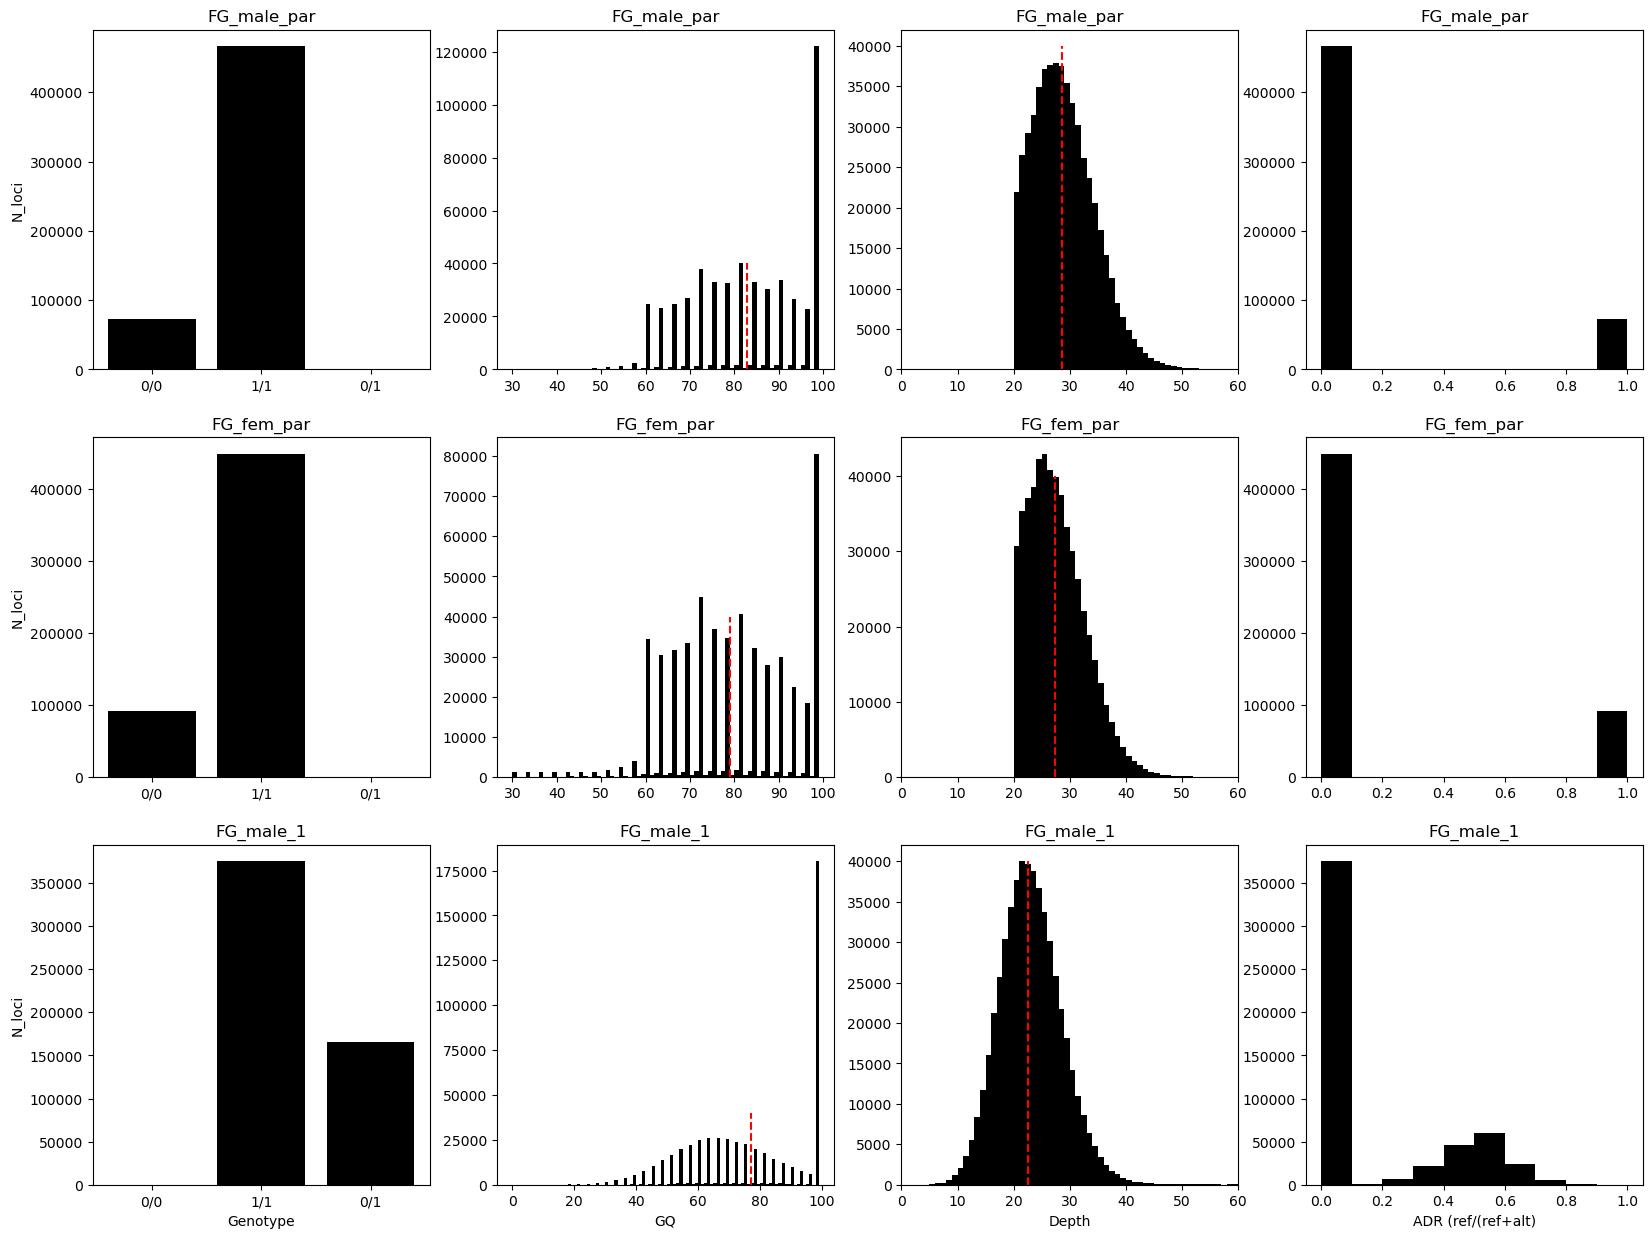

In [586]:
FG_VCF_path = "/Users/dj20y461/Downloads/FG.ALL_TRUTH_VARS_CLEAN.vcf.gz"
FG_outdict_CLEAN = parse_VCF(FG_VCF_path, 9,10,11)

multi_plot(FG_outdict_CLEAN, "FG")

#### KK

Father: KK_male_par
Mother: KK_fem_par
Offspring: KK_male_1


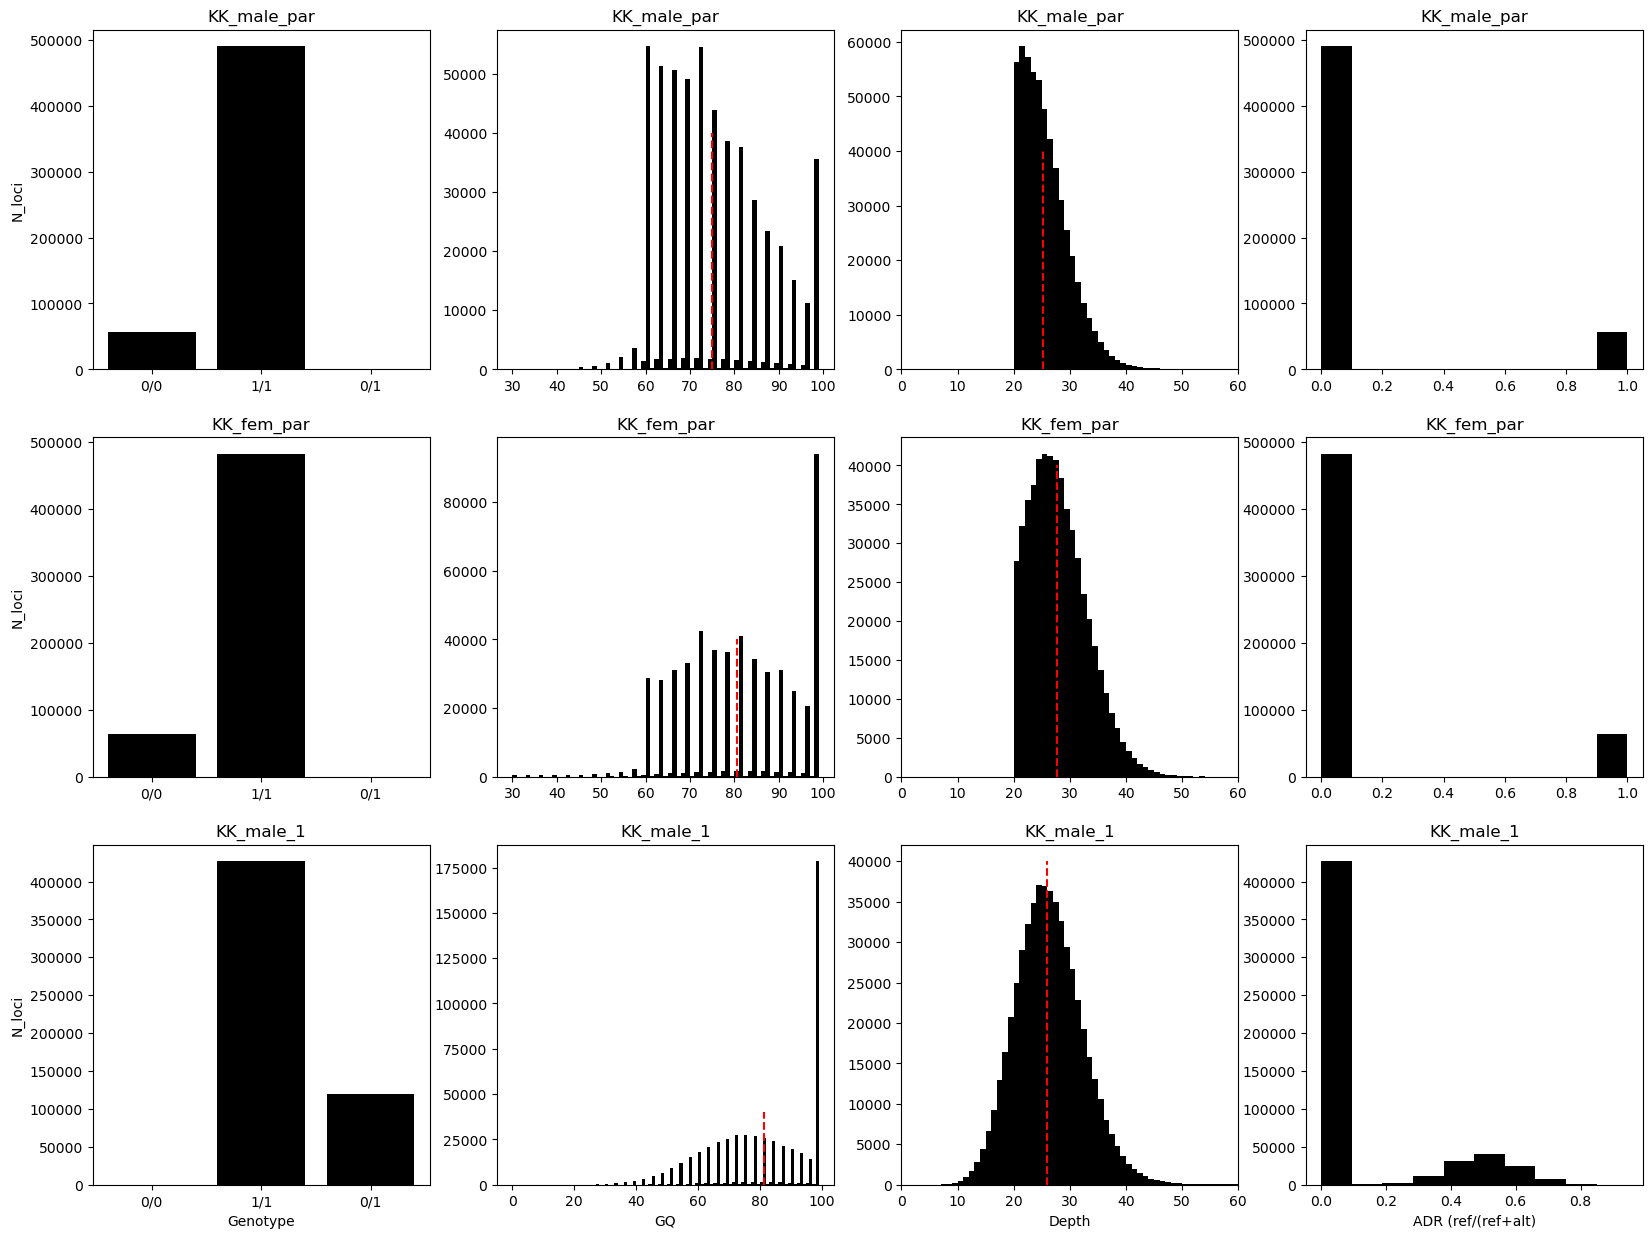

In [587]:
KK_VCF_path = "/Users/dj20y461/Downloads/KK.ALL_TRUTH_VARS_CLEAN.vcf.gz"
KK_outdict_CLEAN = parse_VCF(KK_VCF_path, 9,10,11)

multi_plot(KK_outdict_CLEAN, "KK")

#### SR

Father: SR_male_par
Mother: SR_fem_par
Offspring: SR_male_1


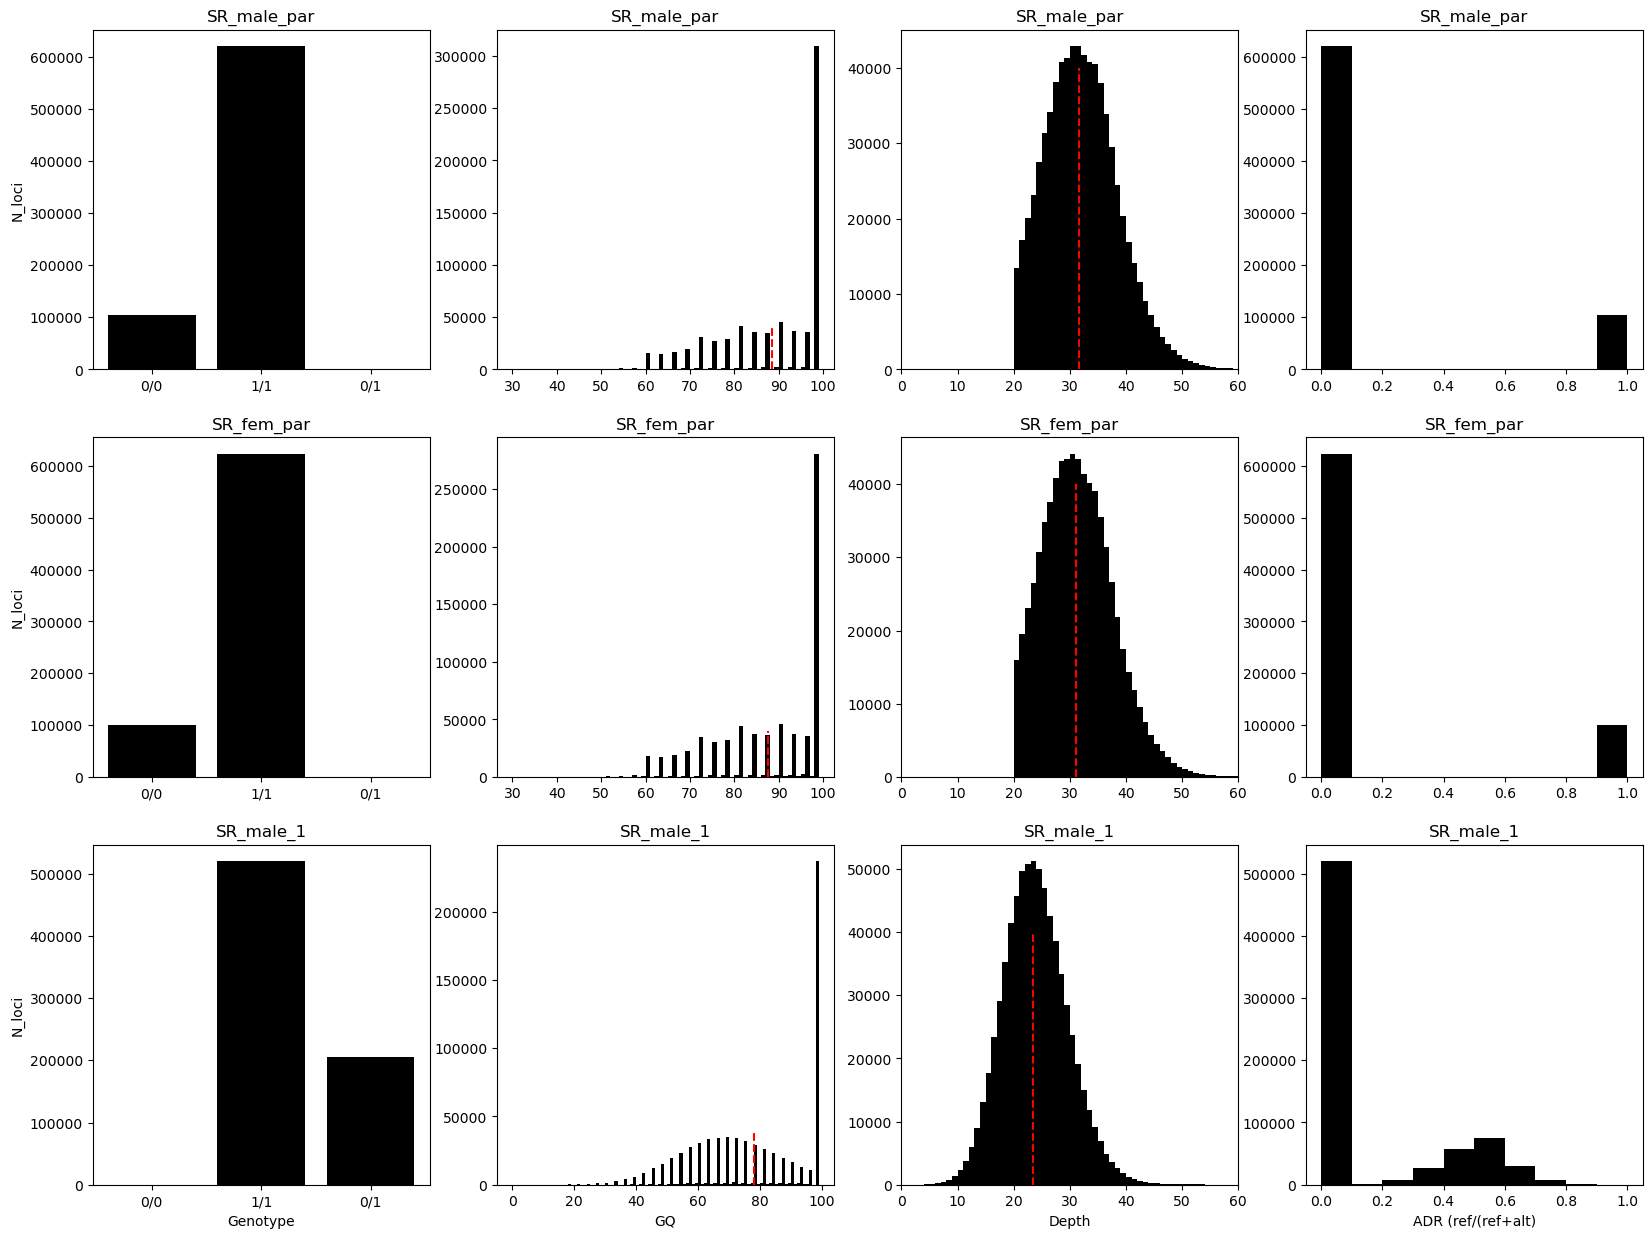

In [588]:
SR_VCF_path = "/Users/dj20y461/Downloads/SR.ALL_TRUTH_VARS_CLEAN.vcf.gz"
SR_outdict_CLEAN = parse_VCF(SR_VCF_path, 9,10,11)

multi_plot(SR_outdict_CLEAN, "SR")

#### TL

Father: TL_male_par
Mother: TL_fem_par
Offspring: TL_male_1


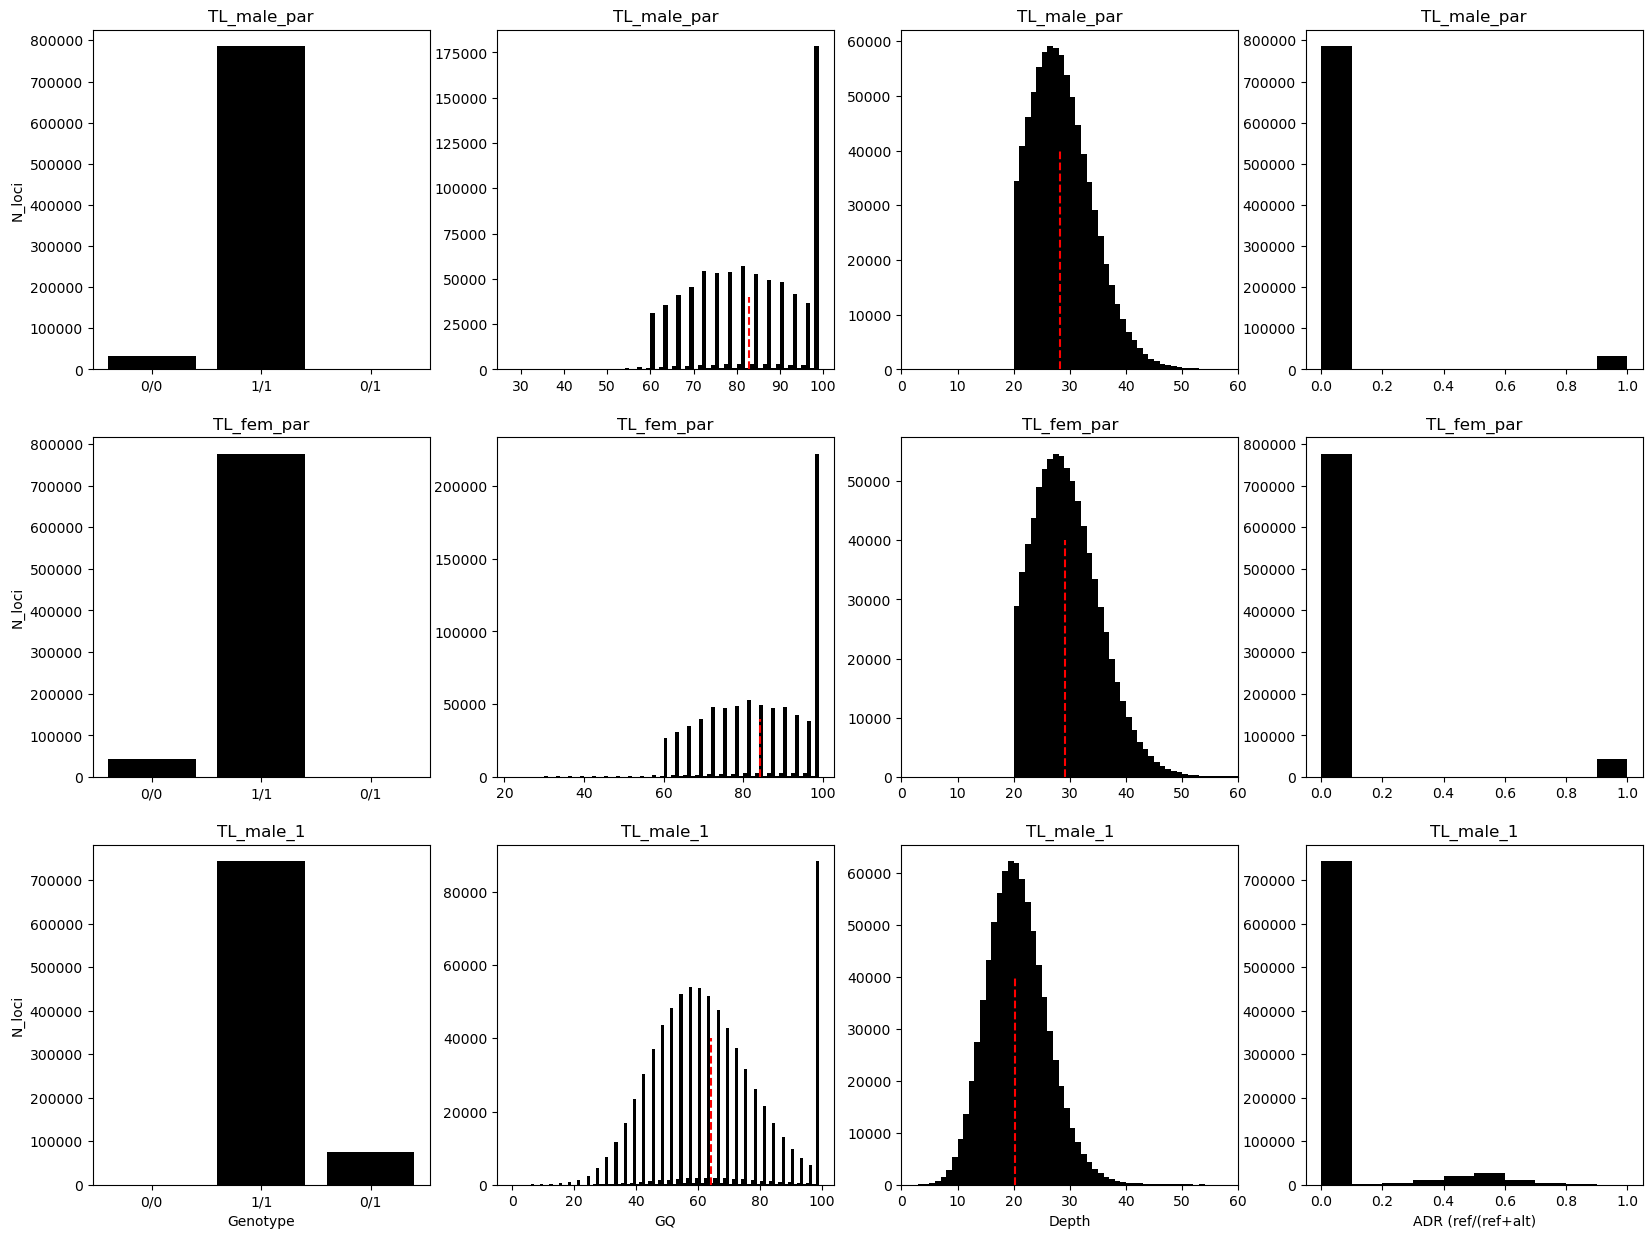

In [589]:
TL_VCF_path = "/Users/dj20y461/Downloads/TL.ALL_TRUTH_VARS_CLEAN.vcf.gz"
TL_outdict_CLEAN = parse_VCF(TL_VCF_path, 9,10,11)

multi_plot(TL_outdict_CLEAN, "TL")

#### WB

Father: WB_male_par
Mother: WB_fem_par
Offspring: WB_male_1


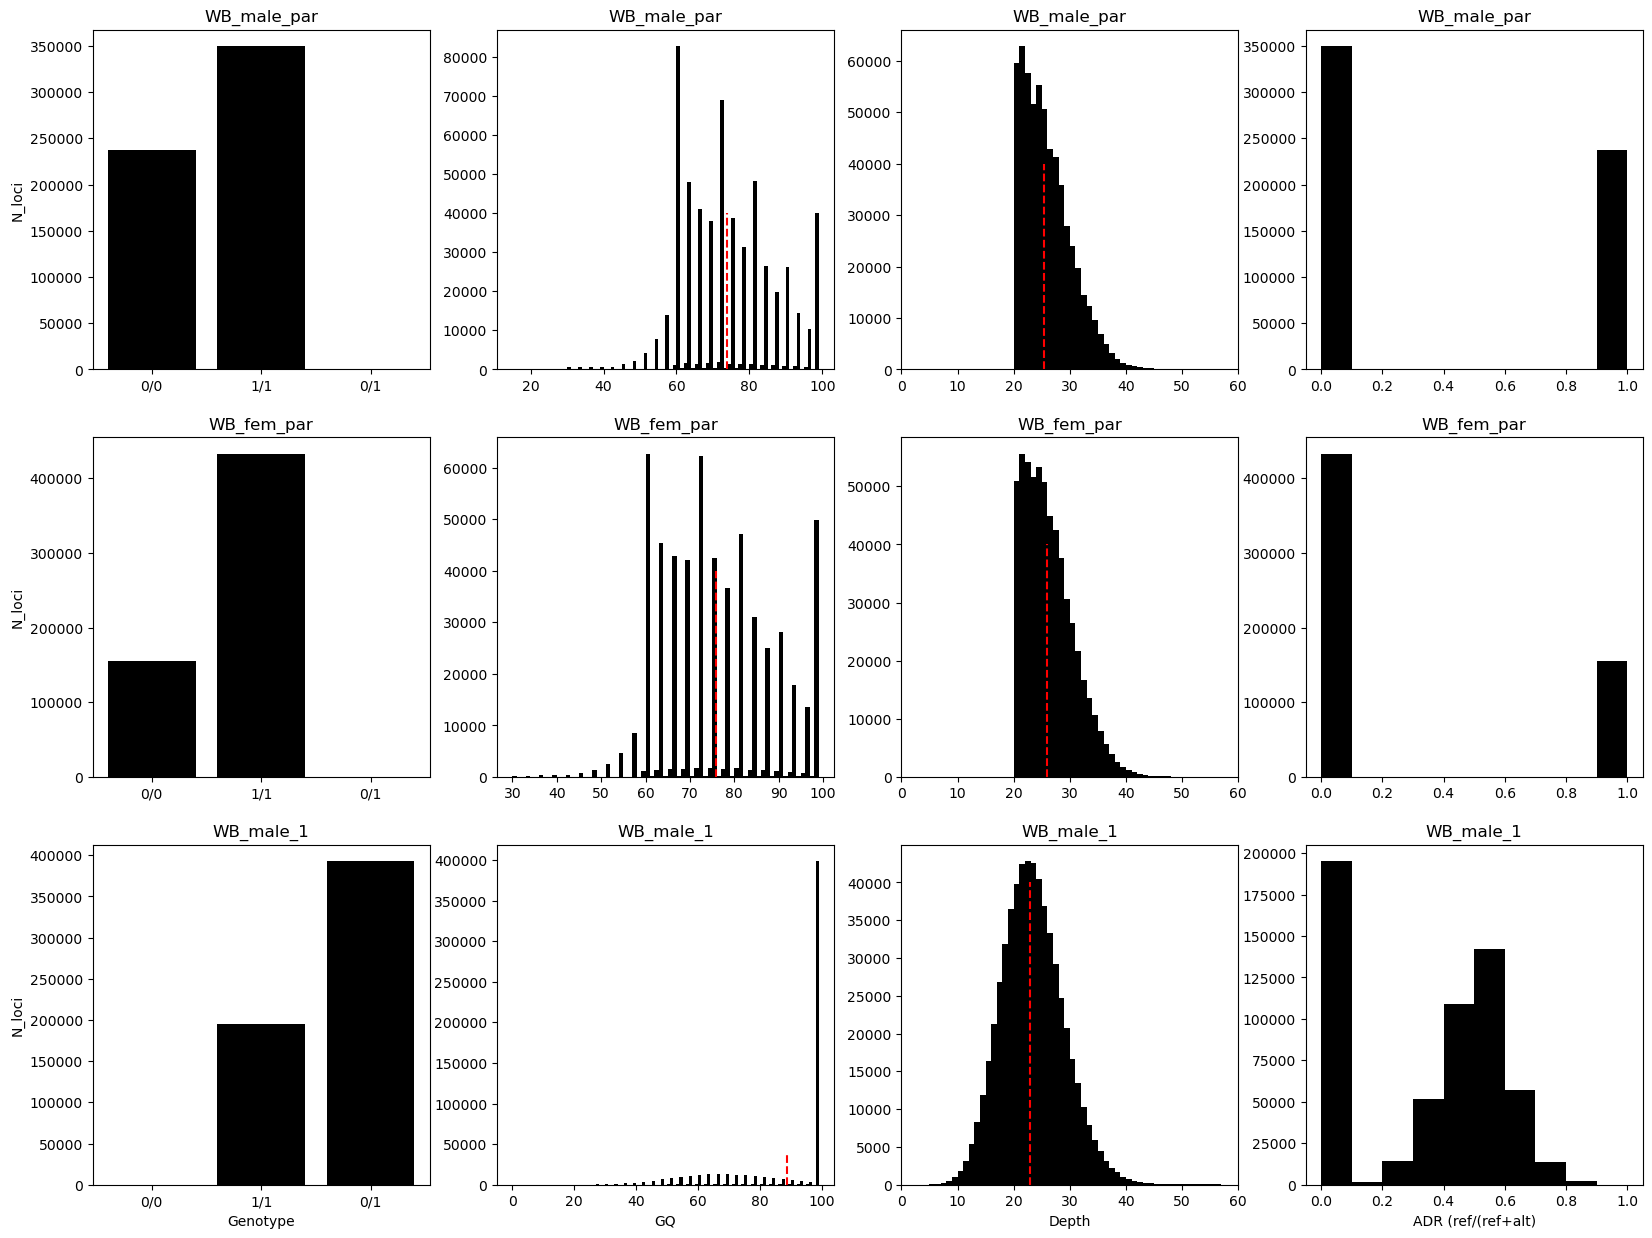

In [590]:
WB_VCF_path = "/Users/dj20y461/Downloads/WB.ALL_TRUTH_VARS_CLEAN.vcf.gz"
WB_outdict_CLEAN = parse_VCF(WB_VCF_path, 9,10,11)

multi_plot(WB_outdict_CLEAN, "WB")

Ok so these all look pretty great to me! The offspring genotypes are as expected, GQs do what we expect, as does depth and ADR. I think these data are ready to be used as the truth vars. 

### Non-Varaint sites 

#### FG

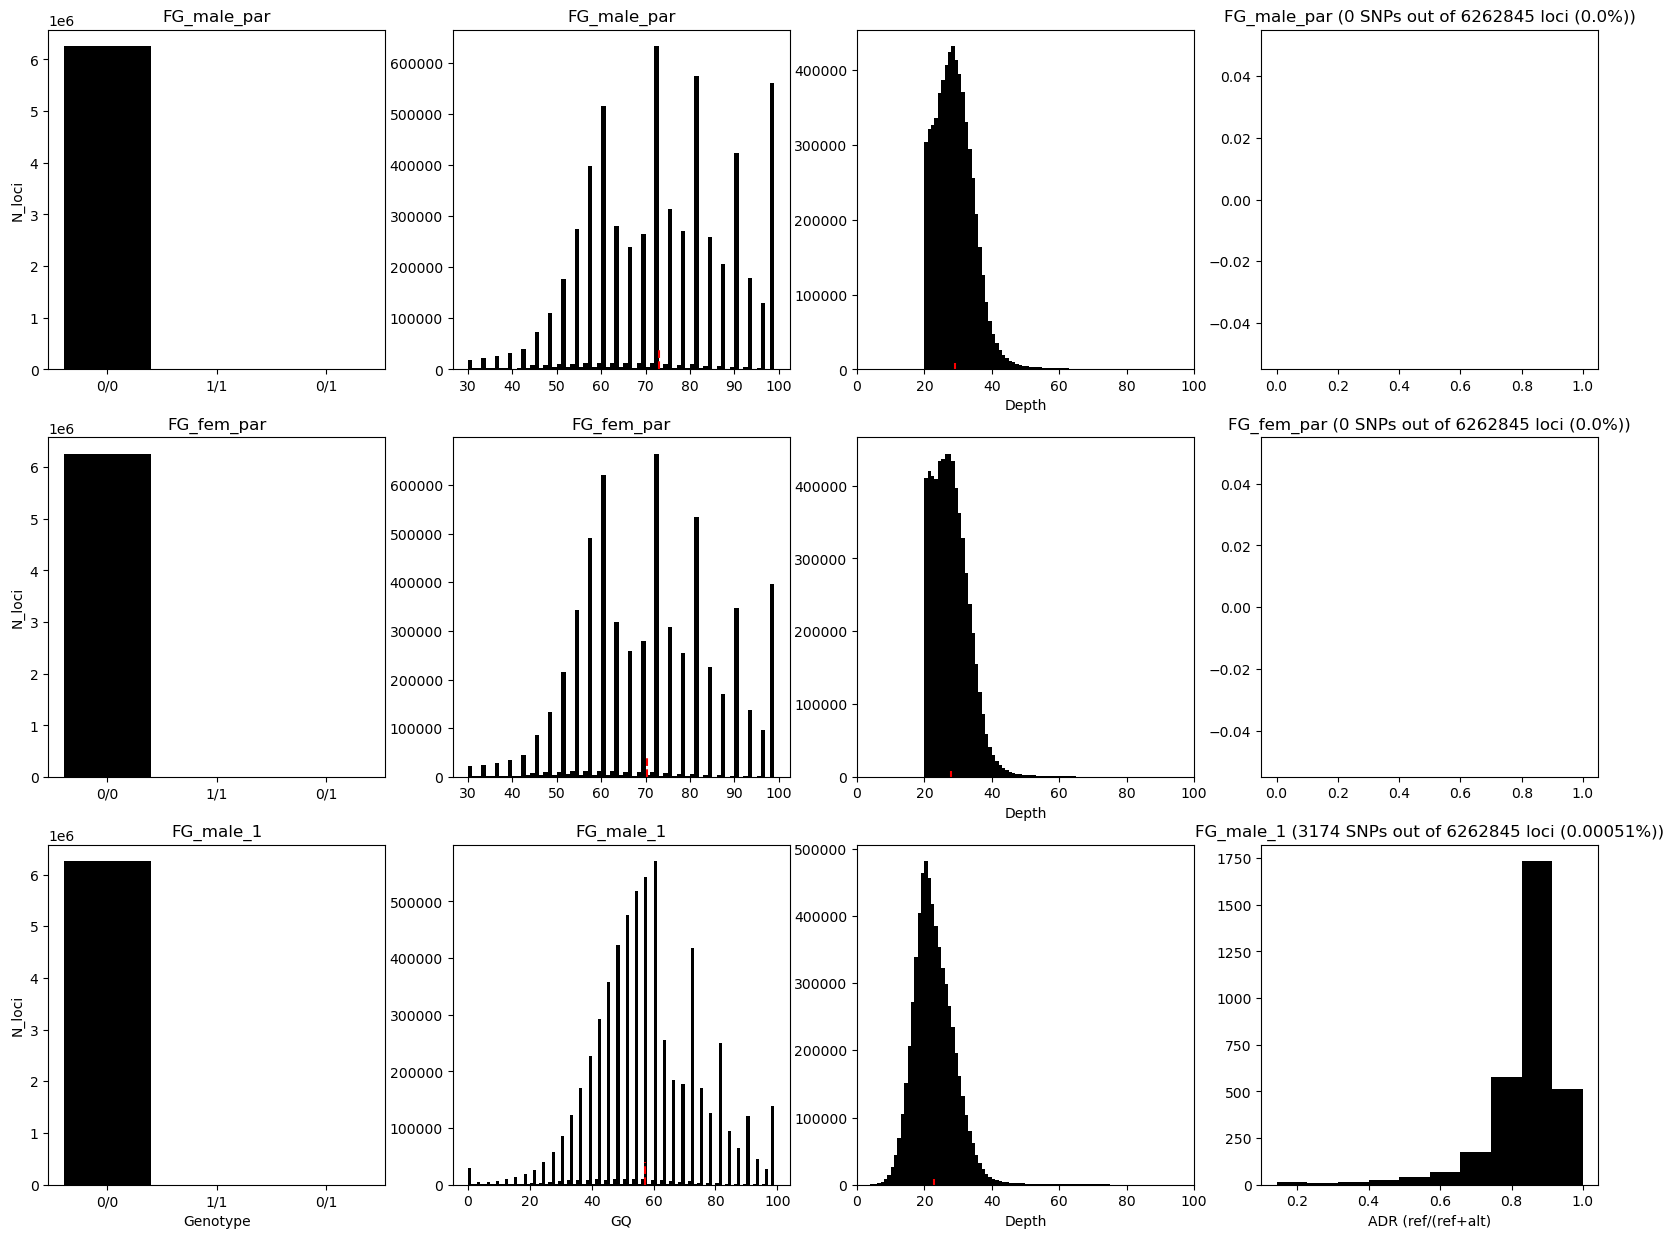

In [89]:
FG_gvcf_path = "/Users/dj20y461/Downloads/FG_putative_nonVar_confident_regions.g.vcf.gz"
FG_gvcf_outdict = parse_GVCF(FG_gvcf_path, 9,10,11)

multi_plot_GVCF(FG_gvcf_outdict, "FG")

#### KK

Father: KK_male_par
Mother: KK_fem_par
Offspring: KK_male_1


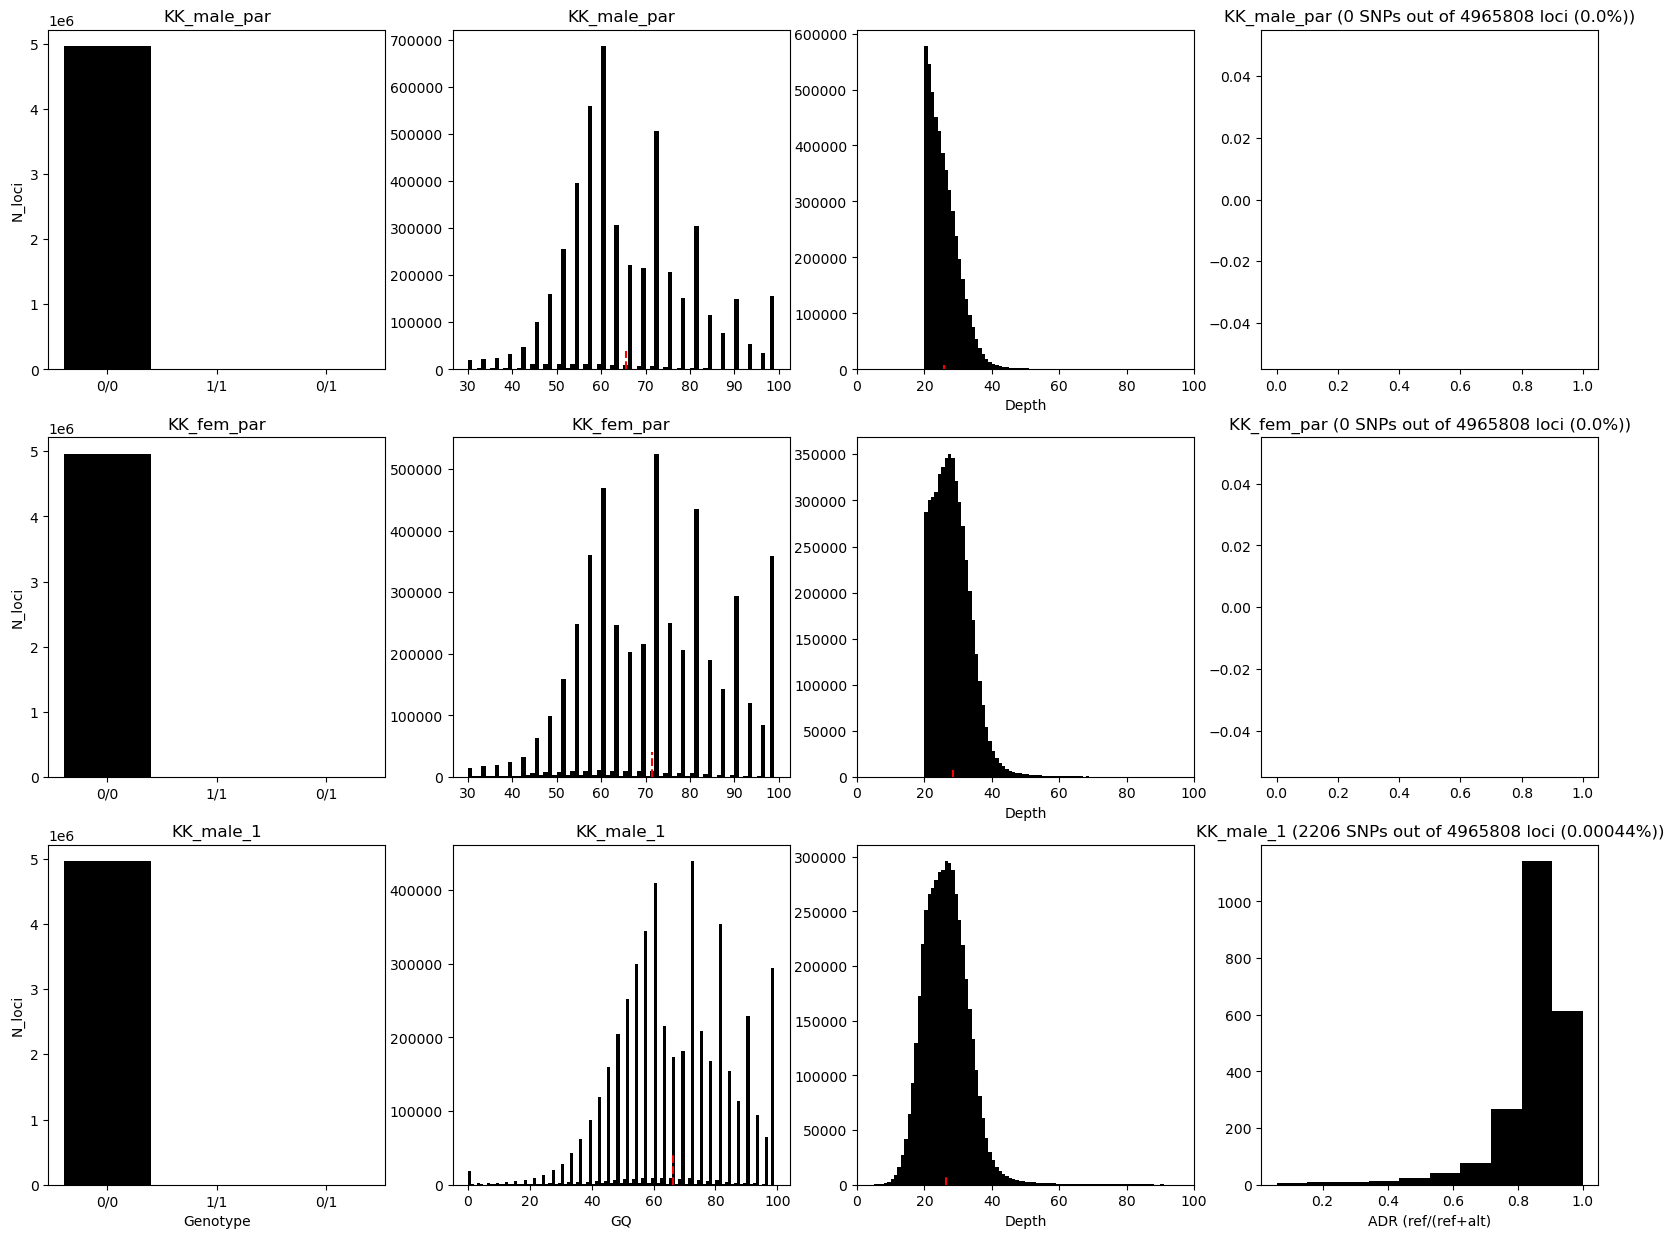

In [91]:
KK_gvcf_path = "/Users/dj20y461/Downloads/KK_putative_nonVar_confident_regions.g.vcf.gz"
KK_gvcf_outdict = parse_GVCF(KK_gvcf_path, 9,10,11)

multi_plot_GVCF(KK_gvcf_outdict, "KK")

#### SR

Father: SR_male_par
Mother: SR_fem_par
Offspring: SR_male_1


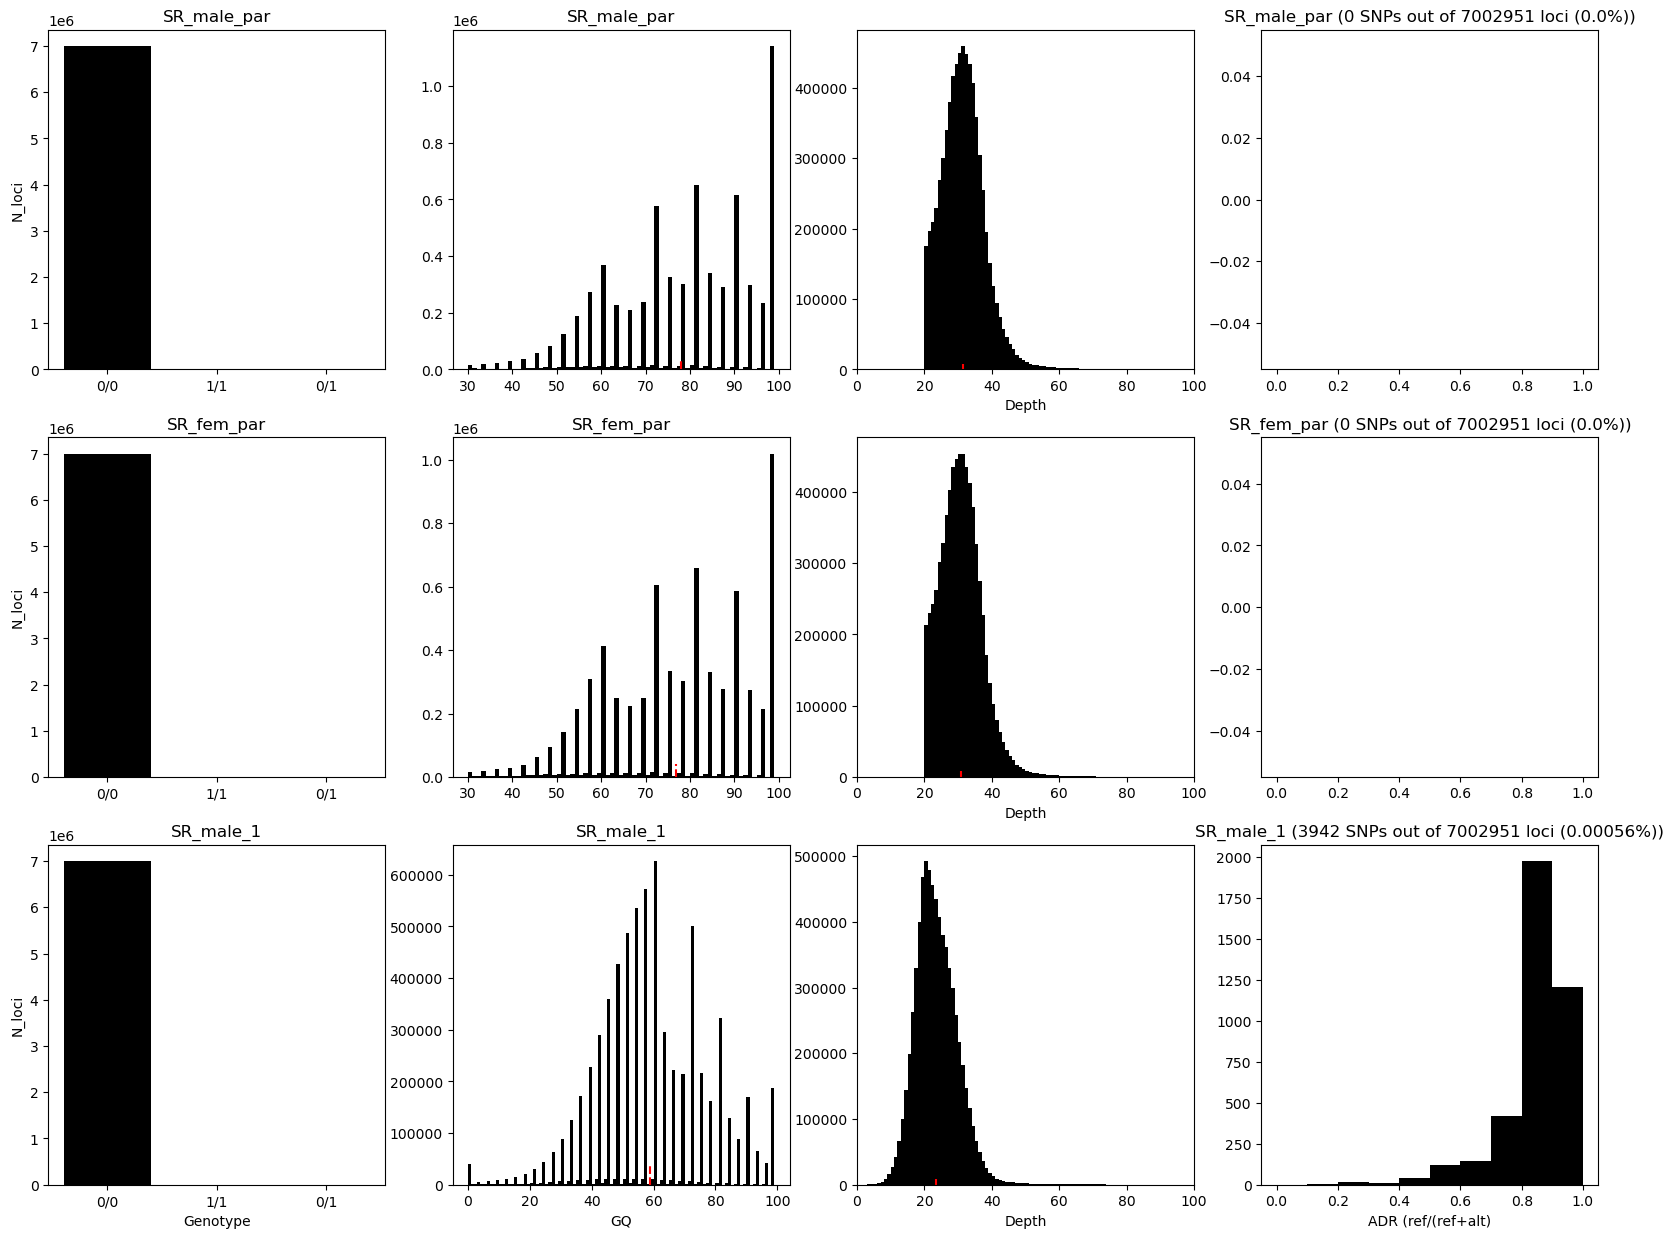

In [92]:
SR_gvcf_path = "/Users/dj20y461/Downloads/SR_putative_nonVar_confident_regions.g.vcf.gz"
SR_gvcf_outdict = parse_GVCF(SR_gvcf_path, 9,10,11)

multi_plot_GVCF(SR_gvcf_outdict, "SR")

#### TL

Father: TL_male_par
Mother: TL_fem_par
Offspring: TL_male_1


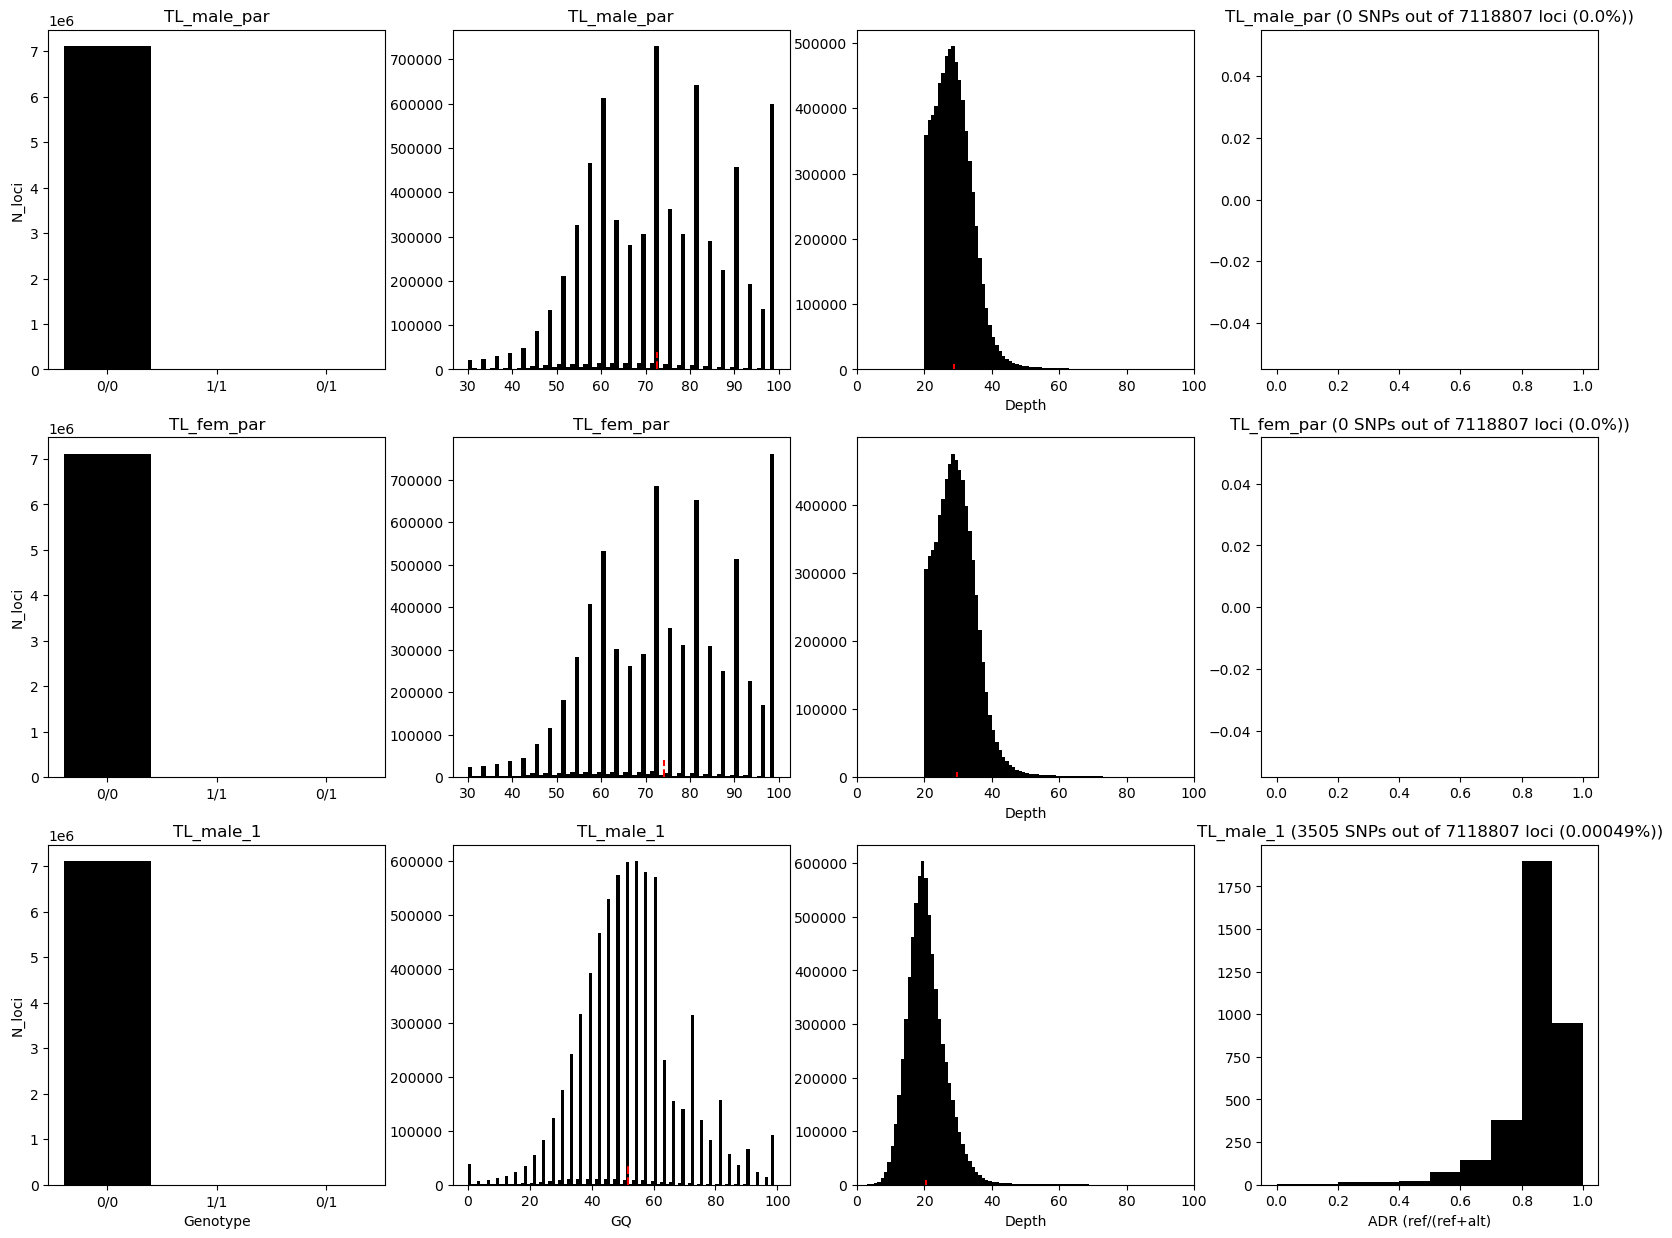

In [93]:
TL_gvcf_path = "/Users/dj20y461/Downloads/TL_putative_nonVar_confident_regions.g.vcf.gz"
TL_gvcf_outdict = parse_GVCF(TL_gvcf_path, 9,10,11)

multi_plot_GVCF(TL_gvcf_outdict, "TL")

#### WB

In [ ]:
WB_gvcf_path = "/Users/dj20y461/Downloads/WB_putative_nonVar_confident_regions.g.vcf.gz"
WB_gvcf_outdict = parse_GVCF(WB_gvcf_path, 9,10,11)

multi_plot_GVCF(WB_gvcf_outdict, "WB")

Father: WB_male_par
Mother: WB_fem_par
Offspring: WB_male_1
